In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from datetime import datetime
from dateutil import parser
geolocator = Nominatim()
%matplotlib inline

In [2]:
loans = pd.read_csv('kiva_loans.csv', parse_dates=True)
map_regions = pd.read_csv('kiva_mpi_region_locations.csv')
theme = pd.read_csv('loan_theme_ids.csv')
theme_by_region = pd.read_csv('loan_themes_by_region.csv')

In [3]:
loans.head(2)

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,NaN,female,irregular,2014-01-01
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,NaN,"female, female",irregular,2014-01-01


In [4]:
# np.datetime64('2014-01-01 06:12:39+00:00')

In [5]:
# loans['dt_posted'] = [np.datetime64(i) for i in loans['posted_time']]

In [6]:
# loans['dt_posted'] = pd.to_datetime(loans['dt_posted'], format='%a %b %d %X')
# loans['dt_posted'][:2]

In [7]:
# year = [i.year for i in loans['dt_posted']]
# month = [i.year for i in loans['dt_posted']]
# loans['year'] = year
# loans['months'] = month

In [8]:
# _2014 = loans[loans['year'] == 2014]
# _2015 = loans[loans['year'] == 2015]
# _2016 = loans[loans['year'] == 2016]
# _2017 = loans[loans['year'] == 2017]

In [9]:
# #year_sector = loans.groupby(['year', 'sector'])['loan_amount'].sum()
# plt.bar( _2014['sector'], _2014['loan_amount'])
# plt.show()

In [10]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671205 entries, 0 to 671204
Data columns (total 20 columns):
id                    671205 non-null int64
funded_amount         671205 non-null float64
loan_amount           671205 non-null float64
activity              671205 non-null object
sector                671205 non-null object
use                   666973 non-null object
country_code          671197 non-null object
country               671205 non-null object
region                614405 non-null object
currency              671205 non-null object
partner_id            657698 non-null float64
posted_time           671205 non-null object
disbursed_time        668809 non-null object
funded_time           622874 non-null object
term_in_months        671205 non-null float64
lender_count          671205 non-null int64
tags                  499789 non-null object
borrower_genders      666984 non-null object
repayment_interval    671205 non-null object
date                  671205 non

Initial observations: <br>
* there are 671205 observations and 20 features <br>
* there are 8 columns with missing observations <br>
<br>
Let's take a look at the columns with missing data

In [11]:
loans.isnull().sum()

id                         0
funded_amount              0
loan_amount                0
activity                   0
sector                     0
use                     4232
country_code               8
country                    0
region                 56800
currency                   0
partner_id             13507
posted_time                0
disbursed_time          2396
funded_time            48331
term_in_months             0
lender_count               0
tags                  171416
borrower_genders        4221
repayment_interval         0
date                       0
dtype: int64

Field Partners do incredible work– they screen borrowers, post loan requests to Kiva for funding, disburse loans on the ground and collect repayments. Most Field Partners are microfinance institutions, but they can also be schools, NGOs or social enterprises.

* there are 8 observations missing form 'country' column <- this can easily be inferred from other columns
* there are 4232 observations missing from 'use' column 
* there are 56800 missing values from region, this may need to be removed - we still have country information; perhaps we can infer this from the map data
* 13507 missing values from field partners
* 2396 missing values from disbursed time
* nearly 200000 tags are missing this column will have to be dropped
* 4221 gender info missing

In [12]:
#missing country codes should not be a problem, we have the country detials
loans[loans['country_code'].isnull()]

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
202537,851360,4150.0,4150.0,Wholesale,Wholesale,To purchase lighting products for sale to loca...,NaN,Namibia,EEnhana,NAD,437.0,2015-03-05 20:23:50+00:00,2015-06-03 07:00:00+00:00,2015-03-25 15:10:03+00:00,6.0,162,"user_favorite, user_favorite",female,bullet,2015-03-05
202823,851368,4150.0,4150.0,Wholesale,Wholesale,To purchase lighting products for sale to loca...,NaN,Namibia,Rundu,NAD,437.0,2015-03-05 20:56:01+00:00,2015-06-03 07:00:00+00:00,2015-03-25 15:48:31+00:00,6.0,159,user_favorite,male,bullet,2015-03-05
344929,991853,3325.0,3325.0,Wholesale,Wholesale,To purchase lighting products for sale to loca...,NaN,Namibia,EEnhana,NAD,437.0,2015-12-08 19:08:18+00:00,2016-01-05 08:00:00+00:00,2015-12-22 03:53:32+00:00,7.0,120,user_favorite,female,bullet,2015-12-08
351177,998555,3325.0,3325.0,Wholesale,Wholesale,To purchase lighting products for sale to loca...,NaN,Namibia,Rundu,NAD,437.0,2015-12-21 19:59:37+00:00,2016-01-05 08:00:00+00:00,2015-12-22 05:58:09+00:00,7.0,126,NaN,male,bullet,2015-12-21
420953,1068167,3325.0,3325.0,Wholesale,Wholesale,To purchase lighting products for sale to loca...,NaN,Namibia,EEnhana,NAD,437.0,2016-05-12 21:33:33+00:00,2016-06-10 07:00:00+00:00,2016-05-15 20:27:57+00:00,7.0,118,"#Repeat Borrower, user_favorite, user_favorite...",female,bullet,2016-05-12
421218,1068159,4000.0,4000.0,Wholesale,Wholesale,purchase solar lighting products for sale to l...,NaN,Namibia,Rundu,NAD,437.0,2016-05-12 21:19:41+00:00,2016-06-10 07:00:00+00:00,2016-05-15 17:36:49+00:00,7.0,150,"#Eco-friendly, #Repeat Borrower, #Technology, ...",male,bullet,2016-05-12
487207,1147852,5100.0,5100.0,Renewable Energy Products,Retail,to pay for stock of solar lights and cell phon...,NaN,Namibia,Katima Mulilo,NAD,437.0,2016-09-08 22:12:16+00:00,2016-10-01 07:00:00+00:00,2016-10-03 21:56:37+00:00,7.0,183,"#Eco-friendly, #Technology, user_favorite, use...",male,bullet,2016-09-08
487653,1147866,5000.0,5000.0,Wholesale,Wholesale,to maintain a stock of solar lights and cell p...,NaN,Namibia,Oshakati,NAD,437.0,2016-09-08 22:30:43+00:00,2016-10-01 07:00:00+00:00,2016-09-19 06:32:16+00:00,7.0,183,"#Eco-friendly, #Technology, user_favorite, use...",female,bullet,2016-09-08


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10cf387b8>,
      dtype=object)

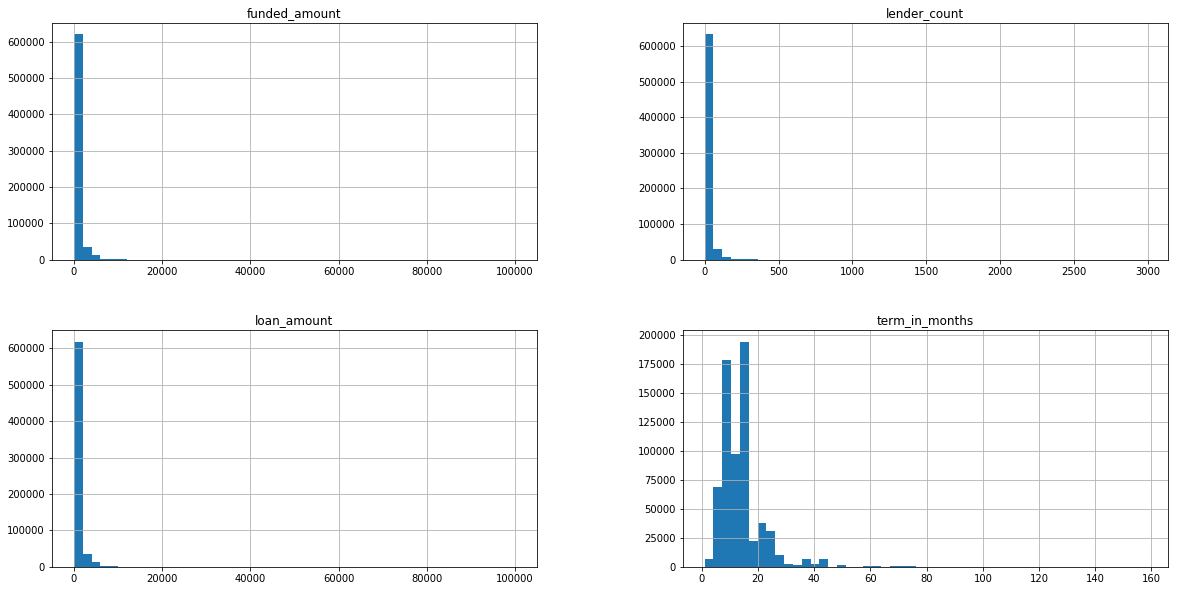

In [13]:
#Let's take a quick look at the distribution of numeric values
loans_num = loans[['funded_amount', 'lender_count', 'loan_amount', 'term_in_months']]
loans_num.hist(bins = 50, figsize = (20,10))

The first funded_amount and loan_amount look very similar. Let's take a closer look.

In [14]:
len(loans)- sum(loans['funded_amount'] == loans['loan_amount'])
#for most of the values, loan amoutn and funded amount oare the same, but not always
#Funded amount: The amount disbursed by Kiva to the field agent(USD)
#Loan amount: The amount disbursed by the field agent to the borrower(USD)

48330

Text(0.5,1,'fund_loan_diff')

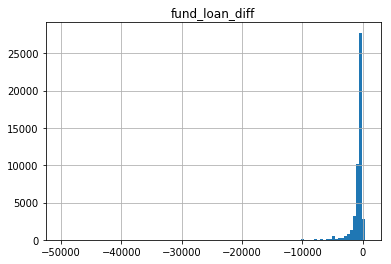

In [15]:
fund_loan_diff = loans['funded_amount'] - loans['loan_amount']
d = [i for i in fund_loan_diff if i != 0]
D = pd.DataFrame(d)
D.hist(bins = 100)
plt.title('fund_loan_diff')

Here, we see that of the 48330 values where the loan amount and the funded amount were not the same, borrowers actually received more money than the amount distributed by KIVA. Suggesting that for these loans, other borrowers were involved.

In [16]:
loans.describe()

,id,funded_amount,loan_amount,partner_id,term_in_months,lender_count
count,6.712050e+05,671205.000000,671205.000000,657698.000000,671205.000000,671205.000000
mean,9.932486e+05,785.995061,842.397107,178.199616,13.739022,20.590922
std,1.966113e+05,1130.398941,1198.660073,94.247581,8.598919,28.459551
min,6.530470e+05,0.000000,25.000000,9.000000,1.000000,0.000000
25%,8.230720e+05,250.000000,275.000000,126.000000,8.000000,7.000000
50%,9.927800e+05,450.000000,500.000000,145.000000,13.000000,13.000000
75%,1.163653e+06,900.000000,1000.000000,204.000000,14.000000,24.000000
max,1.340339e+06,100000.000000,100000.000000,536.000000,158.000000,2986.000000


Here, we see that the majority of the loans were between 25 USD and 1000 USD. Therefore the funded and loan amount of 100000 USD is very peculiar. Let's have a closer look.

In [17]:
loans[loans['funded_amount'] == 100000]

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
70499,722883,100000.0,100000.0,Agriculture,Agriculture,create more than 300 jobs for women and farmer...,HT,Haiti,Les Cayes,USD,315.0,2014-06-10 19:25:02+00:00,2014-09-08 07:00:00+00:00,2014-06-19 20:21:04+00:00,75.0,2986,"user_favorite, user_favorite, user_favorite, u...",female,irregular,2014-06-10


Okay, this makes sense. An amount of $100000 was awarded to Haiti with nearly 3000 lenders. Cross checking this on the [KIVA](https://pages.kiva.org/blog/2017-year-in-review-in-uncertain-times-strangers-lighting-up-lives) website, this seems to be legit, and not an error.

In [18]:
map_regions.head()
#MPI = multidimensional poverty index; takes into account education, health, and standard of living

,LocationName,ISO,country,region,world_region,MPI,geo,lat,lon
0,"Badakhshan, Afghanistan",AFG,Afghanistan,Badakhshan,South Asia,0.387,"(36.7347725, 70.81199529999999)",36.734772,70.811995
1,"Badghis, Afghanistan",AFG,Afghanistan,Badghis,South Asia,0.466,"(35.1671339, 63.7695384)",35.167134,63.769538
2,"Baghlan, Afghanistan",AFG,Afghanistan,Baghlan,South Asia,0.300,"(35.8042947, 69.2877535)",35.804295,69.287754
3,"Balkh, Afghanistan",AFG,Afghanistan,Balkh,South Asia,0.301,"(36.7550603, 66.8975372)",36.755060,66.897537
4,"Bamyan, Afghanistan",AFG,Afghanistan,Bamyan,South Asia,0.325,"(34.8100067, 67.8212104)",34.810007,67.821210


## How are funds being spent?

In [19]:
tmp = loans.groupby('sector')['loan_amount'].sum()

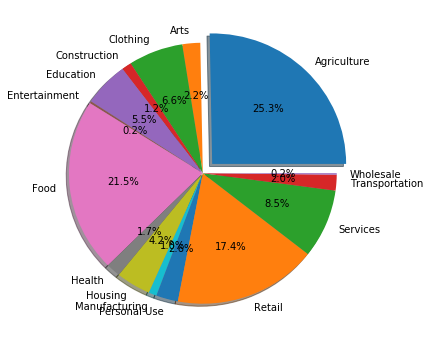

In [20]:
#perhaps sector is better to plt
labels = tmp.index
explode = [0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
plt.figure(figsize = (6, 6))
plt.pie(tmp, labels=labels, shadow = True, autopct='%1.1f%%', explode = explode)
plt.show()

In [21]:
geocodes = pd.read_csv('../geocodes.csv', header=None)
geocodes.columns = ['country', 'lat', 'lon']
geocodes[:5]

,country,lat,lon
0,Afghanistan,33.939110,67.709953
1,Albania,41.153332,20.168331
2,Algeria,28.033886,1.659626
3,Andorra,42.506285,1.521801
4,Angola,-11.202692,17.873887


In [22]:
loans2 = loans.merge(geocodes, how='left', left_on='country', right_on='country')
loans2.head(2)

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,...,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date,lat,lon
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,...,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,NaN,female,irregular,2014-01-01,30.375321,69.345116
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,...,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,NaN,"female, female",irregular,2014-01-01,30.375321,69.345116


In [23]:
loans2['sector'].unique()

array(['Food', 'Transportation', 'Arts', 'Services', 'Agriculture',
       'Manufacturing', 'Wholesale', 'Retail', 'Clothing', 'Construction',
       'Health', 'Education', 'Personal Use', 'Housing', 'Entertainment'],
      dtype=object)

In [24]:
food = loans2[loans2['sector'] == 'Food']
transport = loans2[loans2['sector'] == 'Transportation']
arts = loans2[loans2['sector'] == 'Arts']
services = loans2[loans2['sector'] == 'Services']
agriculture = loans2[loans2['sector'] == 'Agriculture']
manufacturing = loans2[loans2['sector'] == 'Manufacturing']
wholesale = loans2[loans2['sector'] == 'Wholesale']
retail = loans2[loans2['sector'] == 'retail']
clothing = loans2[loans2['sector'] == 'clothing']
construction = loans2[loans2['sector'] == 'Construction']
health = loans2[loans2['sector'] == 'Health']
education = loans2[loans2['sector'] == 'Education']
personal_use = loans2[loans2['sector'] == 'Personal Use']
housing = loans2[loans2['sector'] == 'Housing']
entertainment = loans2[loans2['sector'] == 'Entertainment']

/Users/cherylto/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/cherylto/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/Users/cherylto/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4771: RuntimeWarning: invalid value encountered in greater
  lonsin = np.where(lonsin > lon_0+180, lonsin-360 ,lonsin)
/Users/cherylto/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4772: RuntimeWarning: invalid value encountered in less
  lonsin = np.where(lonsin < lon_0-180, lonsin+360 ,lonsin)
/Users/cherylto/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4776: RuntimeWarning: invalid value encountered in 

Text(0.5,1,'Where is funding being used?')

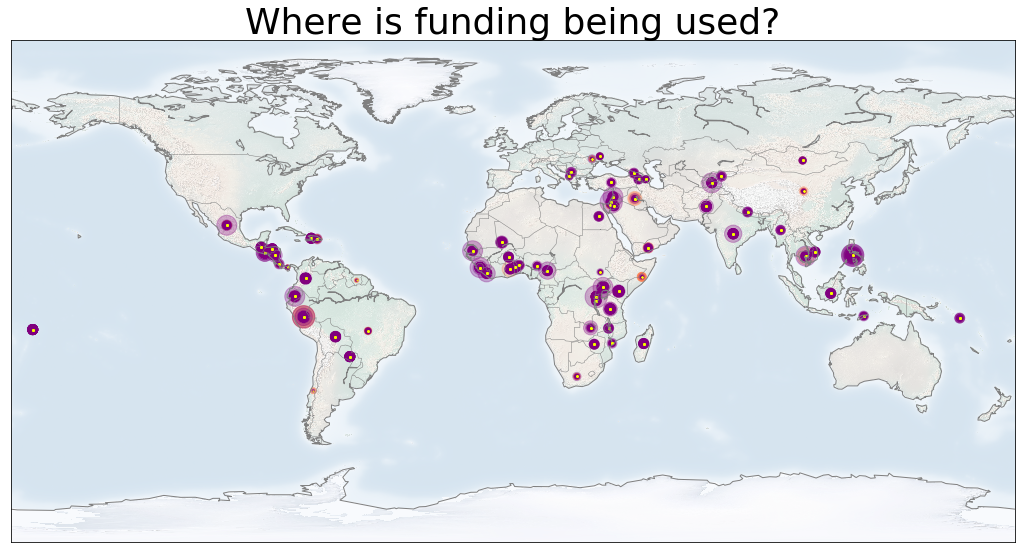

In [25]:
from mpl_toolkits.basemap import Basemap

loan_by_countries = loans.groupby('country')['funded_amount'].sum()
lat = map_regions['lat']
lon = map_regions['lon']

fig = plt.figure(figsize=(18, 15))
cmap = plt.get_cmap('viridis')
map = Basemap(projection='cyl')
map.shadedrelief(alpha = 0.3)
map.drawcoastlines(color='gray')
map.drawcountries(color='gray')
map.scatter(food['lon'], food['lat'], latlon = True, s = food['loan_amount']/100, color = 'coral', alpha = 0.3)
map.scatter(food['lon'], food['lat'], latlon = True, s = services['loan_amount']/100, color = 'purple', alpha = 0.3)
map.scatter(food['lon'], food['lat'], latlon = True, s = retail['loan_amount']/100, color = 'yellow', alpha = 0.3)
plt.title('Where is funding being used?', fontsize=36)



# map.scatter(food['lon'], food['lat'], latlon = True, s = transport['funded_amount']/100, color = 'blue', alpha = 0.3)
# map.scatter(food['lon'], food['lat'], latlon = True, s = arts['funded_amount']/100, color = 'green', alpha = 0.3)
# map.scatter(food['lon'], food['lat'], latlon = True, s = agriculture['funded_amount']/100, color = 'purple', alpha = 0.3)
# map.scatter(food['lon'], food['lat'], latlon = True, s = manufacturing['funded_amount']/100, color = 'purple', alpha = 0.3)
# map.scatter(food['lon'], food['lat'], latlon = True, s = wholesale['funded_amount']/100, color = 'pink', alpha = 0.3)
# map.scatter(food['lon'], food['lat'], latlon = True, s = construction['funded_amount']/100, color = 'orange', alpha = 0.3)
# map.scatter(food['lon'], food['lat'], latlon = True, s = health['funded_amount']/100, color = 'blue', alpha = 0.1)
# map.scatter(food['lon'], food['lat'], latlon = True, s = education['funded_amount']/100, color = 'cyan', alpha = 0.3)

From this we can see that most of the funding, regardless of what the money is for, is being requested by the same ares. Larger circles indicate larger amounts being requested. Greater intensity indicate greater number of times being rquested.

Comparing with the map below, regions that requested funding is more concentrated than regions with low MPI.

although retail was the third highest funding request, these amounts were rather small compared to food and agriculture.

In [26]:
map_regions.head()

,LocationName,ISO,country,region,world_region,MPI,geo,lat,lon
0,"Badakhshan, Afghanistan",AFG,Afghanistan,Badakhshan,South Asia,0.387,"(36.7347725, 70.81199529999999)",36.734772,70.811995
1,"Badghis, Afghanistan",AFG,Afghanistan,Badghis,South Asia,0.466,"(35.1671339, 63.7695384)",35.167134,63.769538
2,"Baghlan, Afghanistan",AFG,Afghanistan,Baghlan,South Asia,0.300,"(35.8042947, 69.2877535)",35.804295,69.287754
3,"Balkh, Afghanistan",AFG,Afghanistan,Balkh,South Asia,0.301,"(36.7550603, 66.8975372)",36.755060,66.897537
4,"Bamyan, Afghanistan",AFG,Afghanistan,Bamyan,South Asia,0.325,"(34.8100067, 67.8212104)",34.810007,67.821210


## MPI Map

/Users/cherylto/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/cherylto/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/Users/cherylto/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4771: RuntimeWarning: invalid value encountered in greater
  lonsin = np.where(lonsin > lon_0+180, lonsin-360 ,lonsin)
/Users/cherylto/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4772: RuntimeWarning: invalid value encountered in less
  lonsin = np.where(lonsin < lon_0-180, lonsin+360 ,lonsin)
/Users/cherylto/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4776: RuntimeWarning: invalid value encountered in 

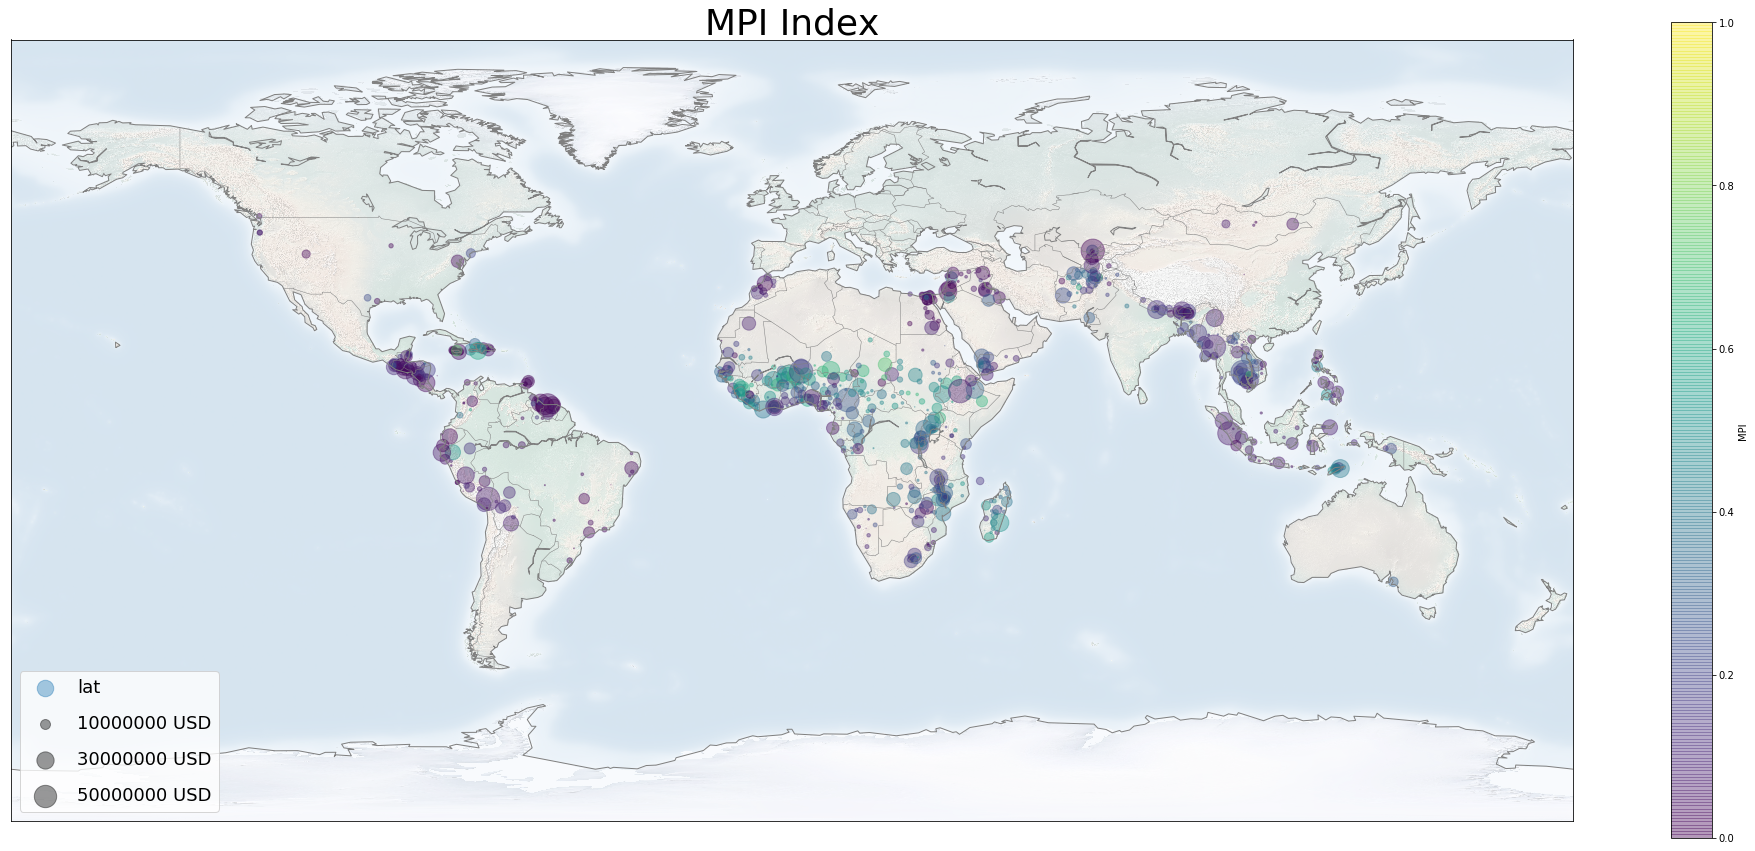

In [27]:
loan_by_countries = loans.groupby('country')['funded_amount'].sum()
lat = map_regions['lat']
lon = map_regions['lon']
c=map_regions['MPI']

fig = plt.figure(figsize=(35, 15))
cmap = plt.get_cmap('viridis')
map = Basemap(projection='cyl')
map.shadedrelief(alpha = 0.3)
map.drawcoastlines(color='gray')
map.drawcountries(color='gray')
map.scatter(lon, lat, latlon=True, c=c, s=loan_by_countries.values/100000, 
            alpha = 0.4)
plt.colorbar(label='MPI')
plt.clim(0,1)
plt.title('MPI Index', fontsize=36)
for a in [100, 300, 500]:
    plt.scatter([], [], c='k', alpha = 0.4, s=a, label=str(a)+'00000 USD')
plt.legend(scatterpoints=1, frameon=True, labelspacing=1, loc='lower left', fontsize=18)
plt.show()


Areas receiving funding seem to be more concentrated than areas with low MPI